In [11]:
library(tidyverse)

Warning message:
"package 'tidyverse' was built under R version 4.0.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.4
v tibble  3.0.1     v dplyr   1.0.2
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

Warning message:
"package 'dplyr' was built under R version 4.0.3"
Warning message:
"package 'forcats' was built under R version 4.0.2"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [19]:
df = read.csv("data/scio_dxa_densidad_28_11.csv")

In [20]:
target = "valor_dxa"
bin_target = paste(target, "bin", sep="_")
s_target = paste(target, '4s', sep="_")

In [21]:
length(unique(df$folio))

[1] 197

### Agrupar por folio y mama

In [28]:
#Agrupar por folio y mama

# df2 = df %>%
#     drop_na() %>%
#     group_by(folio, mama) %>%
#     summarise(
#         !!target := mean(get(target)),
#         Peso = first(peso),
#         edad = first(edad),
#         color = first(fitzpatrickcolor),
#         BMI = first(indicedemasacorporal),
#         copa_sosten = first(copasosten),
#         across(starts_with("spectrum"), mean), 
#         across(starts_with("sample_raw"), mean)
#     ) %>%
#     ungroup()

df2 = df2 %>%
    mutate(
#         !!bin_target := ifelse(
#             get(target) > quantile(get(target), 0.75),
#             "high_density",
#             "low_density"
#         ),
        !!bin_target := ifelse(
            get(target) > 50,
            "high_density",
            "low_density"
        ),
        !!s_target := case_when(
            get(target) >  quantile(get(target), 0.75) ~ 'HIGH',
            get(target) < quantile(get(target), 0.25) ~ 'LOW',
            TRUE ~ 'MEDIUM'
        ),            
#         BMI_segment = case_when(
#             BMI < quantile(BMI, 0.25) ~ "BMI_1_Quartil",
#             BMI < quantile(BMI, 0.5) ~ "BMI_2_Quartil",
#             BMI < quantile(BMI, 0.75) ~ "BMI_3_Quartil",
#             TRUE ~ "BMI_4_Quartil"
#         ),
        BMI_segment = case_when(
            BMI < 18 ~ "<18",
            BMI < 25 ~ "18-25",
            BMI < 30 ~ "25-30",
            TRUE ~ ">30"
        )
    )

### Agrupar por valor de densidad

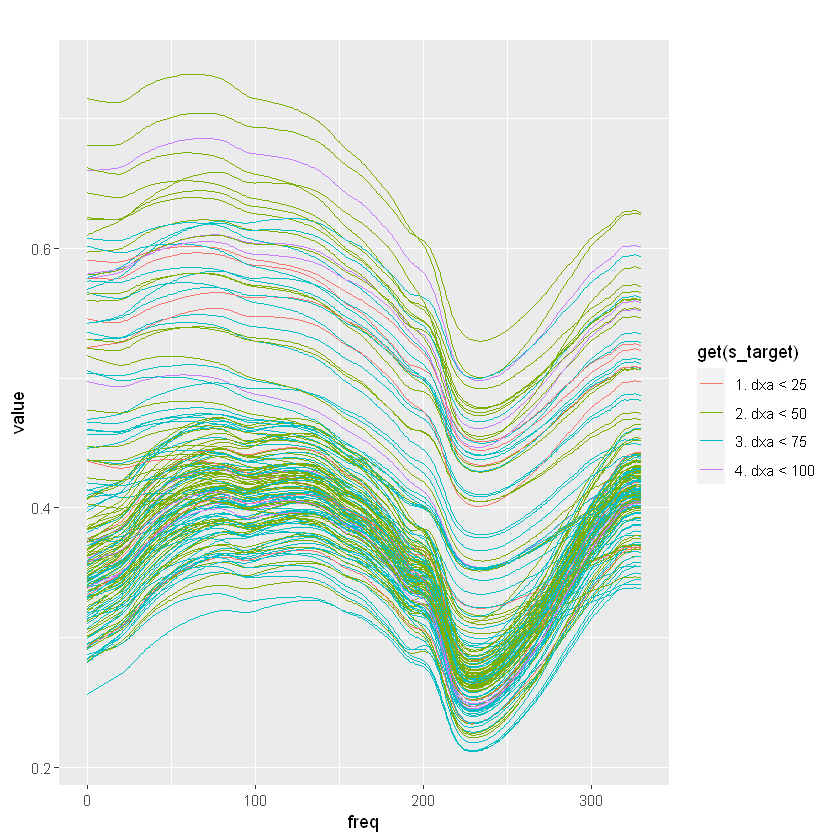

In [40]:
# Agrupar por valor de densidad

df2 %>%
    filter(
        spectrum_0 < 0.9
    ) %>%
    select(- c(target, BMI, Peso)) %>%
    pivot_longer(
        cols = !c(!!bin_target, !!s_target, BMI_segment, folio, copa_sosten, edad), 
        names_to = "series",
        values_to = "value",
        values_drop_na = TRUE
    ) %>%
    mutate(
        serie = str_replace(series, "_.*", ""),
        freq = as.numeric(str_replace(series, ".*_", ""))
    ) %>%
    filter(serie == 'spectrum') %>%
    ungroup() %>%
#     group_by(.dots = bin_target, freq, BMI_segment) %>%
#     summarize(value = mean(value)) %>%
#     ungroup()  %>%
    ggplot(aes(
        x = freq, 
        y = value, 
        color = get(s_target),
        group = folio
        )
    ) +
    geom_line() +
#     facet_wrap(~ ) +
    ggtitle('')
        

### Histograma de densidad dxa

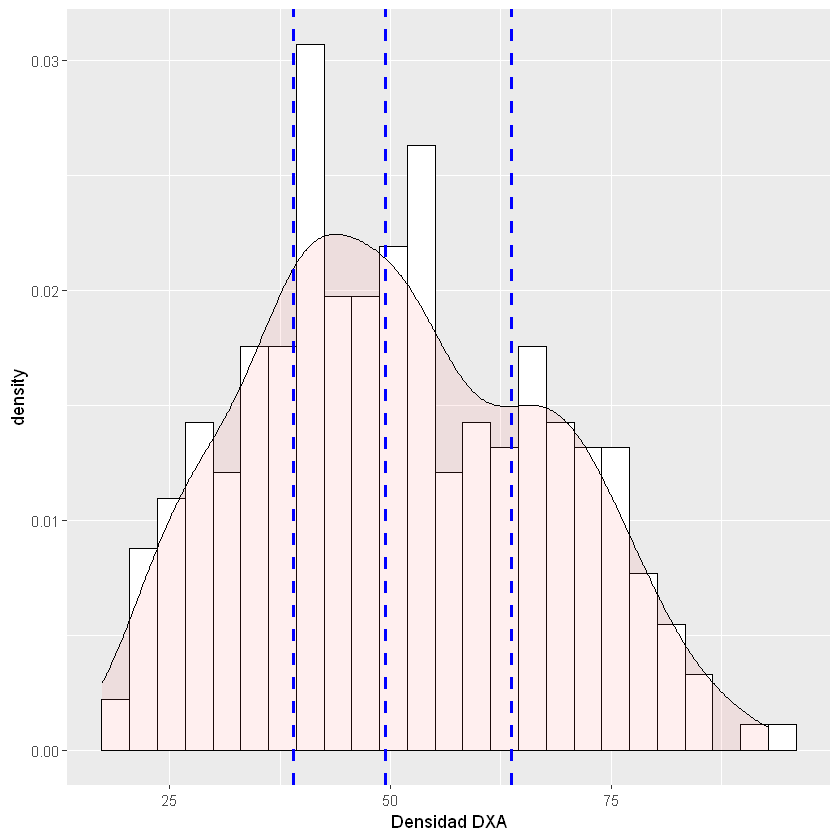

In [24]:
# Histograma de densidad dxa

df2 %>%
  filter(
        !folio %in% folio_filter &
        mama != 'left_2'
    ) %>%
    ggplot(aes(x=get(target))) +
    geom_histogram(aes(y=..density..), 
                   bins=25, color='black', fill='white') + 
    geom_density(alpha=.1, fill="#FF6666") + 
    geom_vline(aes(xintercept=quantile(get(target), 0.5)), 
               color="blue", linetype="dashed", size=1) + 
    geom_vline(aes(xintercept=quantile(get(target), 0.75)), 
               color="blue", linetype="dashed", size=1) +
    geom_vline(aes(xintercept=quantile(get(target), 0.25)), 
               color="blue", linetype="dashed", size=1) +
    xlab('Densidad DXA')

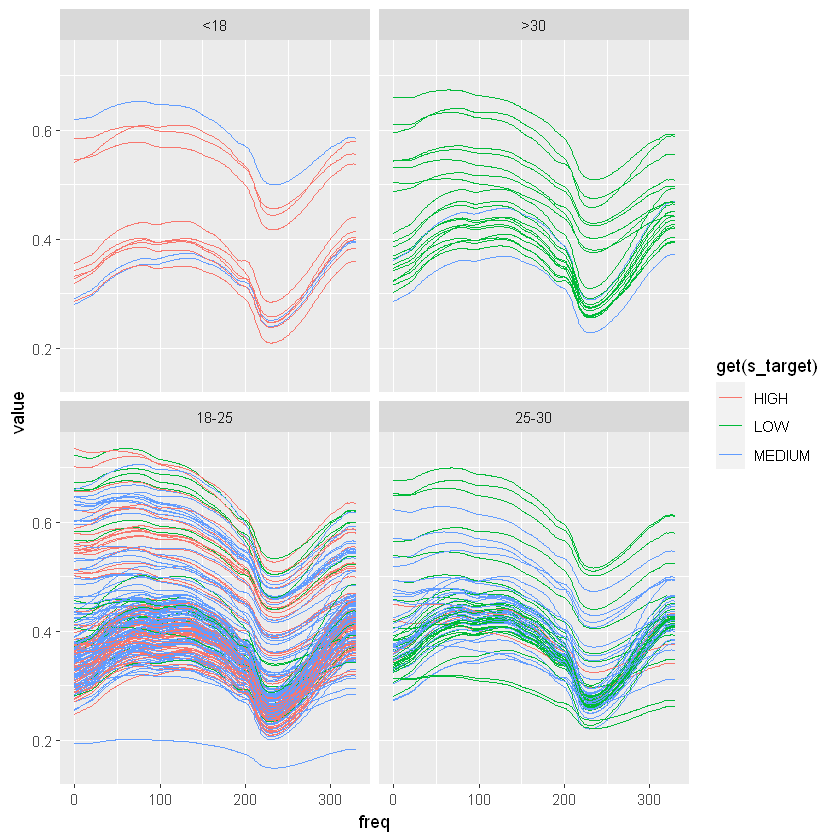

In [30]:
# Separar por color

df2 %>%
    filter(
        !folio %in% folio_filter &
        mama != 'left_2'
    ) %>%
    select(- c(target, BMI, Peso)) %>%
    pivot_longer(
        cols = !c(!!bin_target, !!s_target, BMI_segment, folio, copa_sosten, edad, color, mama), 
        names_to = "series",
        values_to = "value",
        values_drop_na = TRUE
    ) %>%
    mutate(
        serie = str_replace(series, "_.*", ""),
        freq = as.numeric(str_replace(series, ".*_", ""))
    ) %>%
    filter(serie == 'spectrum') %>%
#     ungroup() %>%
#     group_by(.dots = s_target, freq, BMI_segment) %>%
#     summarize(value = mean(value)) %>%
    ungroup()  %>%
    ggplot(aes(
        x = freq, 
        y = value, 
        color = get(s_target),
        group = interaction(folio, mama)
        )
    ) +
    geom_line() +
    facet_wrap(~ BMI_segment)

In [ ]:
# Separar por BMI por mama

df2 %>%
    filter(
        !folio %in% folio_filter
    ) %>%
    select(- c(target, BMI, Peso)) %>%
    pivot_longer(
        cols = !c(!!bin_target, !!s_target, BMI_segment, folio, copa_sosten, edad, color, mama), 
        names_to = "series",
        values_to = "value",
        values_drop_na = TRUE
    ) %>%
    mutate(
        serie = str_replace(series, "_.*", ""),
        freq = as.numeric(str_replace(series, ".*_", ""))
    ) %>%
    filter(serie == 'spectrum') %>%
    ungroup() %>%
    group_by(.dots = bin_target, freq, BMI_segment) %>%
    summarize(value = mean(value)) %>%
    ungroup()  %>%
    ggplot(aes(
        x = freq, 
        y = value, 
        color = get(bin_target),
#         group = folio
        )
    ) +
    geom_line() +
    facet_wrap(~ BMI_segment)

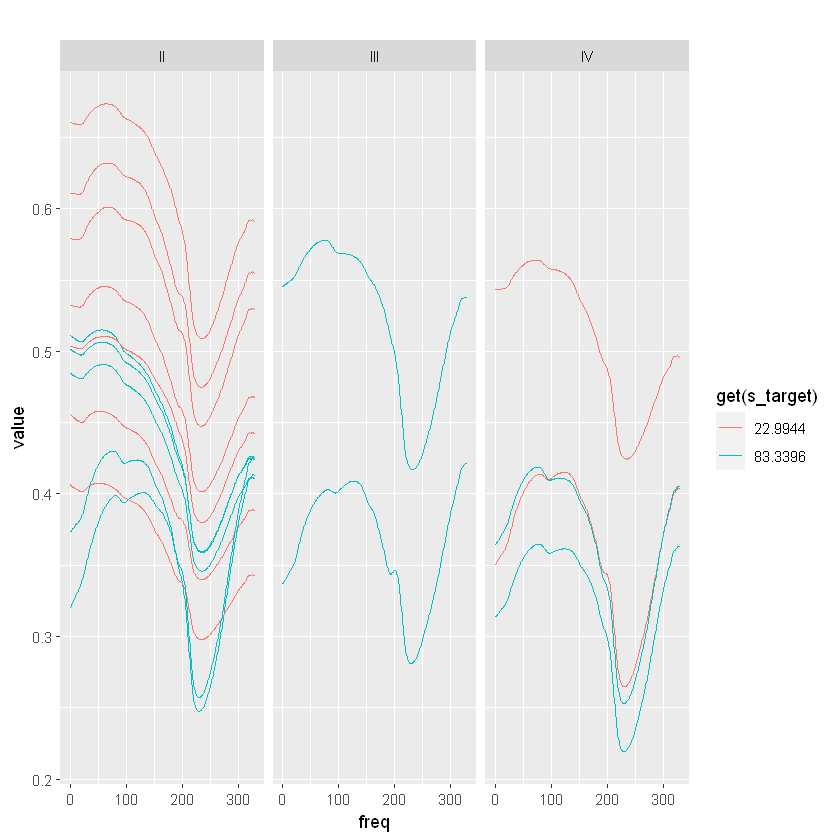

In [42]:
# Casos extremos

df2 %>%
    filter(
        get(s_target) != 'other'
    ) %>%
    select(- c(target, BMI, Peso)) %>%
    pivot_longer(
        cols = !c(!!bin_target, !!s_target, BMI_segment, folio, copa_sosten, edad, color, mama), 
        names_to = "series",
        values_to = "value",
        values_drop_na = TRUE
    ) %>%
    mutate(
        serie = str_replace(series, "_.*", ""),
        freq = as.numeric(str_replace(series, ".*_", ""))
    ) %>%
    filter(serie == 'spectrum') %>%
    ungroup() %>%
#     group_by(.dots = s_target, freq, color) %>%
#     summarize(value = mean(value)) %>%
#     ungroup()  %>%
    ggplot(aes(
        x = freq, 
        y = value, 
        color = get(s_target),
        group = interaction(folio, mama)
        )
    ) +
    geom_line() +
    facet_wrap(~ color) +
    ggtitle('')

In [7]:
# Variabilidad entre mamas izquierdas

# df2 = df %>%
#   drop_na() %>%
#   filter(mama %in% c('left', 'left_2')) %>%
#   group_by(folio, mama) %>%
#   summarise(
#         !!target := mean(get(target)),
#         across(starts_with("spectrum"), mean),
#     ) %>%
#   ungroup()

# df3 = df2 %>%
#   group_by(folio) %>%
#   summarize(
#     across(starts_with("spectrum"), mean, .names='mean_{.col}'),
#     across(starts_with("spectrum"), sd, .names="sd_{.col}"),
#     across(starts_with("spectrum"), ~ sd(.x) / mean(.x), .names="cv_{.col}")
#   ) %>%
#   ungroup()

# Histogram
# df3 %>%
#   ungroup() %>%
#   rowwise(folio) %>%
#   summarize(mean_cv = mean(c_across(cv_spectrum_0: cv_spectrum_330))) %>%
#   ggplot(aes(x = mean_cv)) +
#     geom_histogram()

df4 = df2 %>%
  pivot_wider(
    id_cols = folio,
    names_from = mama,
    values_from = spectrum_0: spectrum_330
  )
for(i in 0:330){
  df4[, paste("var", i, sep="_")] = (df4[, paste("spectrum", i, "left", sep="_")] / df4[, paste("spectrum", i, "left_2", sep="_")] - 1) * 100
}
# Percentual variation
df4 %>% 
  ungroup() %>%
  rowwise(folio) %>%
  summarize(mean_perc_var = mean(c_across(var_0: var_330))) %>%
  ggplot(aes(x = mean_perc_var)) +
    geom_histogram()

Warning message:
"Values in `spectrum_0` are not uniquely identified; output will contain list-cols.
* Use `values_fn = list(spectrum_0 = list)` to suppress this warning.
* Use `values_fn = list(spectrum_0 = length)` to identify where the duplicates arise
* Use `values_fn = list(spectrum_0 = summary_fun)` to summarise duplicates"
Warning message:
"Values in `spectrum_1` are not uniquely identified; output will contain list-cols.
* Use `values_fn = list(spectrum_1 = list)` to suppress this warning.
* Use `values_fn = list(spectrum_1 = length)` to identify where the duplicates arise
* Use `values_fn = list(spectrum_1 = summary_fun)` to summarise duplicates"
Warning message:
"Values in `spectrum_10` are not uniquely identified; output will contain list-cols.
* Use `values_fn = list(spectrum_10 = list)` to suppress this warning.
* Use `values_fn = list(spectrum_10 = length)` to identify where the duplicates arise
* Use `values_fn = list(spectrum_10 = summary_fun)` to summarise duplicates"


ERROR: Error in FUN(left, right): argumento no-numérico para operador binario


In [17]:
# Variabilidad entre mamas izquierdas v2

map_ubicacion = function(x){
  if(grepl('-12', x)){return('12')}
  if(grepl('-3', x)){return('3')}
  if(grepl('-6', x)){return('6')}
  if(grepl('-9', x)){return('9')}
  if(grepl('-Pezon', x)){return('pezon')}
}

df2 = df %>%
  drop_na() %>%
  filter(mama %in% c('left', 'left_2')) %>%
  mutate(loc = map(ubicacion, map_ubicacion)) %>%
  filter(loc != 'pezon') %>%
  group_by(folio, mama, loc) %>%
  summarise(
        !!target := mean(get(target)),
        across(starts_with("spectrum"), mean),
    ) %>%
  ungroup() 

# df3 = df2 %>%
#   group_by(folio) %>%
#   summarize(
#     across(starts_with("spectrum"), mean, .names='mean_{.col}'),
#     across(starts_with("spectrum"), sd, .names="sd_{.col}"),
#     across(starts_with("spectrum"), ~ sd(.x) / mean(.x), .names="cv_{.col}")
#   ) %>%
#   ungroup()

# Histogram
# df3 %>%
#   ungroup() %>%
#   rowwise(folio) %>%
#   summarize(mean_cv = mean(c_across(cv_spectrum_0: cv_spectrum_330))) %>%
#   ggplot(aes(x = mean_cv)) +
#     geom_histogram()

df4 = df2 %>%
  pivot_wider(
    id_cols = c(folio, loc),
    names_from = mama,
    values_from = spectrum_0: spectrum_330
  )

for(i in 0:330){
  df4[, paste("perc_var", i, sep="_")] = abs((df4[, paste("spectrum", i, "left", sep="_")] / df4[, paste("spectrum", i, "left_2", sep="_")] - 1) * 100)
}
for(i in 0:330){
  df4[, paste('distance', i, sep="_")] = 4 * (df4[, paste('spectrum', i, 'left', sep="_")] - df4[, paste('spectrum', i, 'left_2', sep="_")]) ^ 2 / ((df4[, paste('spectrum', i, 'left', sep="_")] + df4[, paste('spectrum', i, 'left_2', sep="_")]))^2
}

# Percentual variation
aux = df4 %>% 
  ungroup() %>%
  rowwise(folio, loc) %>%
  summarize(mean_perc_var = mean(c_across(perc_var_0:perc_var_330)),
            mean_dist = mean(c_across(distance_0:distance_330))) %>%
  group_by(folio) %>%
  summarize(perc_var = mean(mean_perc_var),
            distance = sum(mean_dist)
            ) 
#   filter(perc_var < 11) %>%
#   nrow() 
# %>%
#   ggplot(aes(x=perc_var)) +
#   geom_histogram()

folio_filter = aux %>%
  filter(perc_var > 15) %>%
  select(folio)

`summarise()` regrouping output by 'folio', 'mama' (override with `.groups` argument)

`summarise()` regrouping output by 'folio', 'loc' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [34]:
# Variabilidad entre ninas (mama izq 1)

# df2 = df %>%
#   drop_na() %>%
#   filter(mama == 'left') %>%
#   group_by(ubicacion) %>%
#   mutate(across(starts_with("spectrum"), mean, .names='mean_{.col}'))

# for(i in 0:330){
#   df2[, paste('dif', i, sep="_")] = abs(df2[, paste('spectrum', i, sep='_')] / df2[, paste('mean_spectrum', i, sep='_')] - 1)
#   }

aux2 = df2 %>% 
  group_by(folio) %>%
  summarize(mean_perc_var = mean(c_across(dif_0:dif_330))) %>%
  rowwise(folio) %>%
  summarize(perc_var = mean(mean_perc_var)) %>%
  mutate(type = 'entre ninas',
         perc_var = perc_var * 100) %>%
  select(folio, type, perc_var)



`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'folio' (override with `.groups` argument)



`summarise()` ungrouping output (override with `.groups` argument)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bin)."


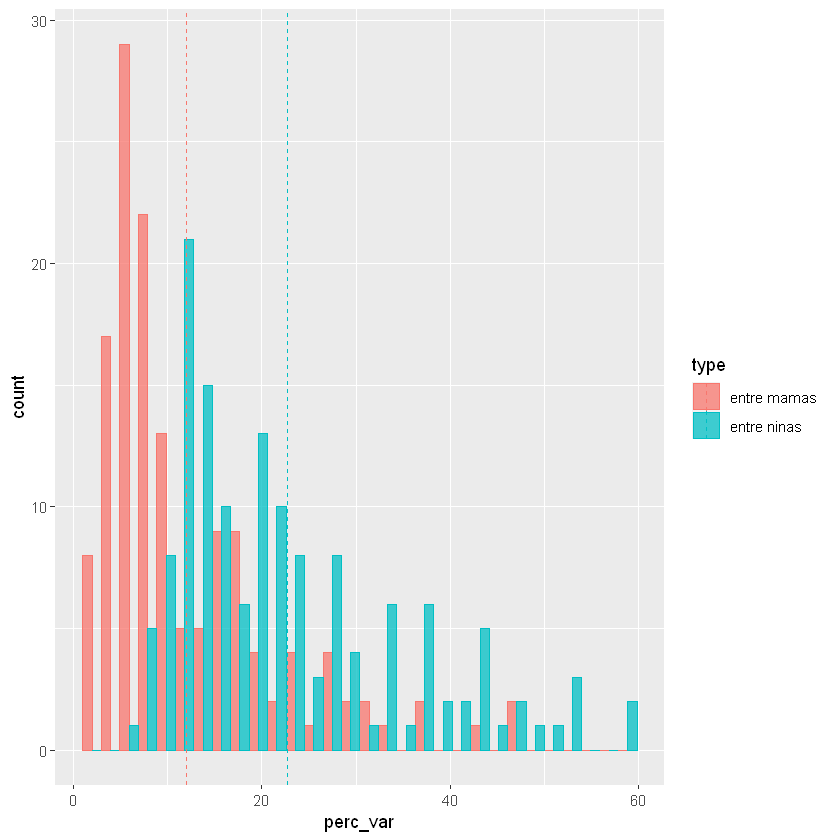

In [46]:
promedio = aux %>%
  mutate(type = 'entre mamas') %>%
  select(folio, type, perc_var) %>%
  rbind(aux2) %>%
  drop_na() %>%
  group_by(type) %>%
  summarize(mean_var = mean(perc_var))

aux %>%
  mutate(type = 'entre mamas') %>%
  select(folio, type, perc_var) %>%
  rbind(aux2) %>%
  ggplot(aes(x=perc_var, color=type, fill=type)) +
  geom_histogram(alpha=0.75, position="dodge") + 
  geom_vline(data=promedio, 
             aes(xintercept=mean_var, color=type),
             linetype="dashed")

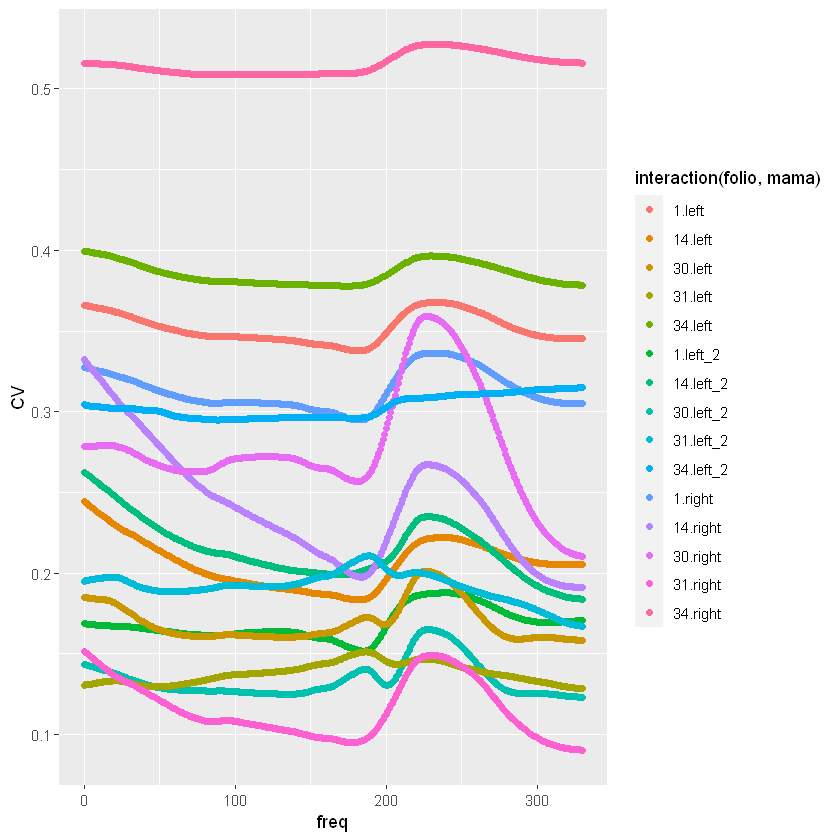

In [30]:
# Variabilidad dentro de la mama

# df2 = df %>%
#   drop_na() %>%
#   group_by(folio, mama, ubicacion) %>%
#   summarise(
#         !!target := mean(get(target)),
#         across(starts_with("spectrum"), mean),
#     ) %>%
#   ungroup()

# df3 = df2 %>%
#   group_by(folio, mama) %>%
#   summarize(
#     !!target := mean(get(target)),
#     across(starts_with("spectrum"), mean, .names='mean_{.col}'),
#     across(starts_with("spectrum"), sd, .names="sd_{.col}"),
#     across(starts_with("spectrum"), ~ sd(.x) / mean(.x), .names="cv_{.col}")
#   ) %>%
#   ungroup()

# Histogram
# df3 %>%
#   rowwise() %>%
#   summarize(mean_cv = mean(c_across(cv_spectrum_0: cv_spectrum_330))) %>%
#   ggplot(aes(x = mean_cv)) +
#     geom_histogram()

# Scatter plot with dxa/variability of measurements
# df3 %>%
#   rowwise() %>%
#   mutate(mean_cv = mean(c_across(cv_spectrum_0: cv_spectrum_330)),
#          sd_cv = sd(c_across(cv_spectrum_0: cv_spectrum_330))) %>%
#   ungroup() %>%
#   mutate(cv = sd_cv / mean_cv) %>%
#   ggplot(aes(
#     y = cv,
#     x = get(target)
#     )
#   ) +
#   geom_point() +
#   xlab('DXA')

# df3 %>%
#   rowwise() %>%
#   mutate(mean_cv = mean(c_across(cv_spectrum_0: cv_spectrum_330)),
#          sd_cv = sd(c_across(cv_spectrum_0: cv_spectrum_330))) %>%
#   ungroup() %>%
#   mutate(cv = sd_cv / mean_cv) %>%
#   ggplot(aes(
#     y = cv,
#     x = get(target)
#     )
#   ) +
#   geom_point() +
#   xlab('DXA')

df3 %>%
  pivot_longer(
        cols = !c(!!target, folio, mama), 
        names_to = "series",
        values_to = "value",
        values_drop_na = TRUE
    ) %>%
  mutate(
      serie = str_replace(series, "_.*", ""),
      freq = as.numeric(str_replace(series, ".*_", ""))
  ) %>%
  filter(folio < 40 & serie == 'cv') %>%
  mutate(folio = as.factor(folio)) %>%
  ggplot(aes(
    x = freq,
    y = value,
    color = interaction(folio, mama)
    )
  ) + 
  geom_point() +
  ylab('CV')


`summarise()` regrouping output by 'freq', 'BMI_segment' (override with `.groups` argument)



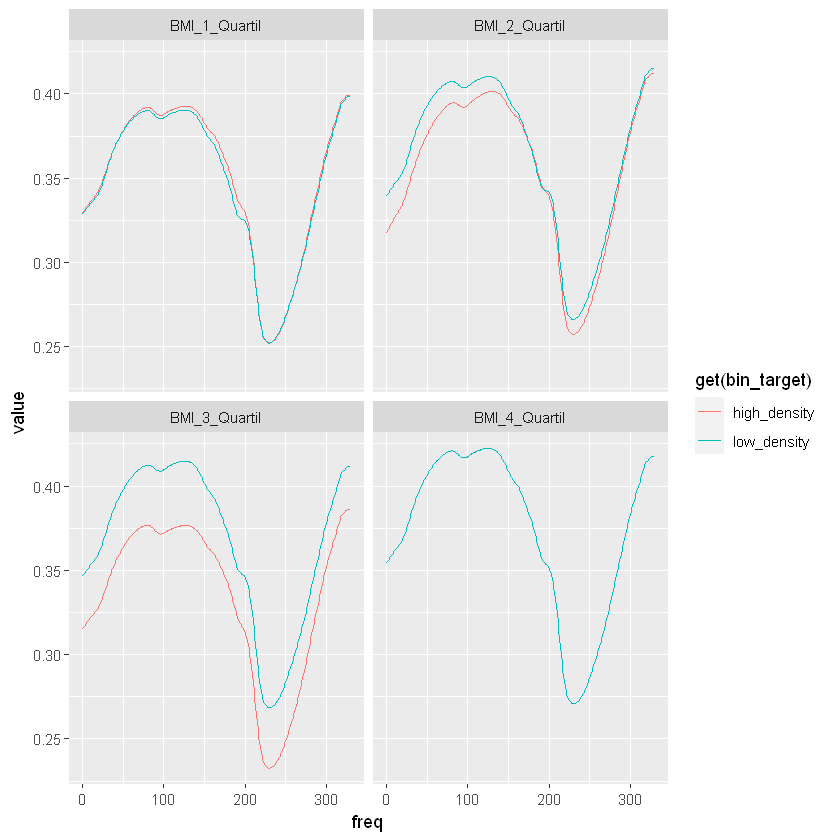

In [25]:
df2 %>%
    filter(
        spectrum_0 < 0.5
    ) %>%
    select(- c(target, BMI, Peso)) %>%
    pivot_longer(
        cols = !c(!!bin_target, BMI_segment, folio, copa_sosten, peso_segment, edad), 
        names_to = "series",
        values_to = "value",
        values_drop_na = TRUE
    ) %>%
    mutate(
        serie = str_replace(series, "_.*", ""),
        freq = as.numeric(str_replace(series, ".*_", ""))
    ) %>%
    filter(serie == 'spectrum') %>%
    ungroup() %>%
    group_by(.dots = bin_target, freq, BMI_segment) %>%
    summarize(value = mean(value)) %>%
    ungroup()  %>%
    ggplot(aes(
        x = freq, 
        y = value, 
        color = get(bin_target),
#         group = folio
        )
    ) +
    geom_line() +
    facet_wrap(~ BMI_segment)
        

`summarise()` regrouping output by 'freq' (override with `.groups` argument)



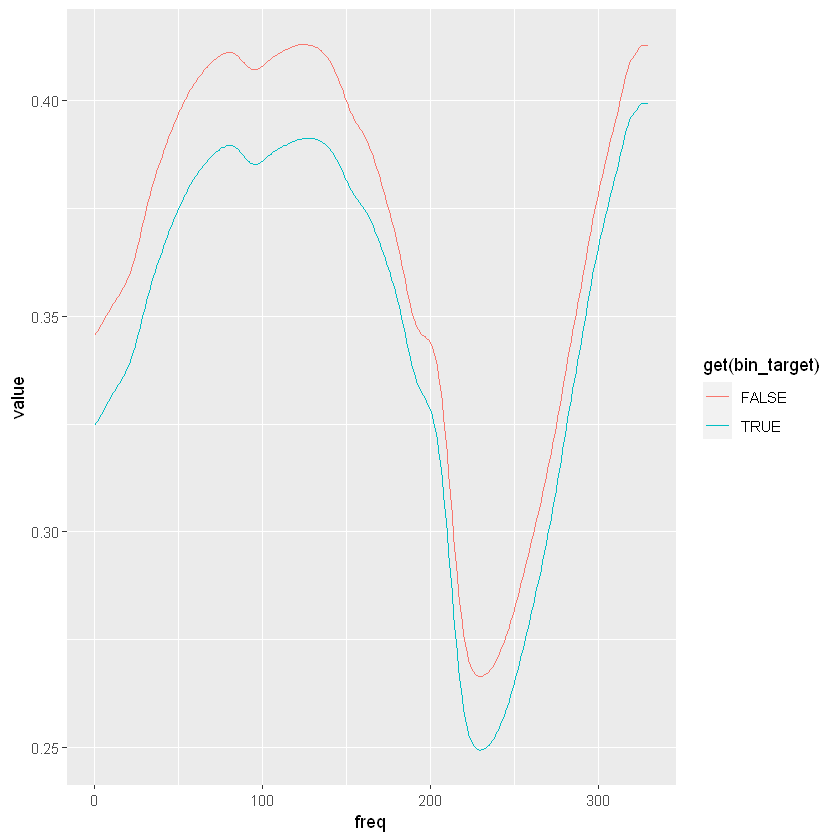

In [153]:
df2 %>%
    filter(
        spectrum_0 < 0.5 &
        (get(target) > quantile(get(target), 0.75) | 
        get(target) < quantile(get(target), 0.75))
    ) %>%
    select(- target) %>%
    pivot_longer(
        cols = !c(!!bin_target, folio), 
        names_to = "series",
        values_to = "value",
        values_drop_na = TRUE
    ) %>%
    mutate(
        serie = str_replace(series, "_.*", ""),
        freq = as.numeric(str_replace(series, ".*_", ""))
    ) %>%
    filter(serie == 'spectrum') %>%
    ungroup() %>%
    group_by(.dots = bin_target, freq) %>%
    summarize(value = mean(value)) %>%
    ungroup()  %>%
    ggplot(aes(
        x = freq, 
        y = value, 
        color = get(bin_target)
        )
    ) +
    geom_line()
           

`summarise()` regrouping output by 'freq_group', 'folio' (override with `.groups` argument)



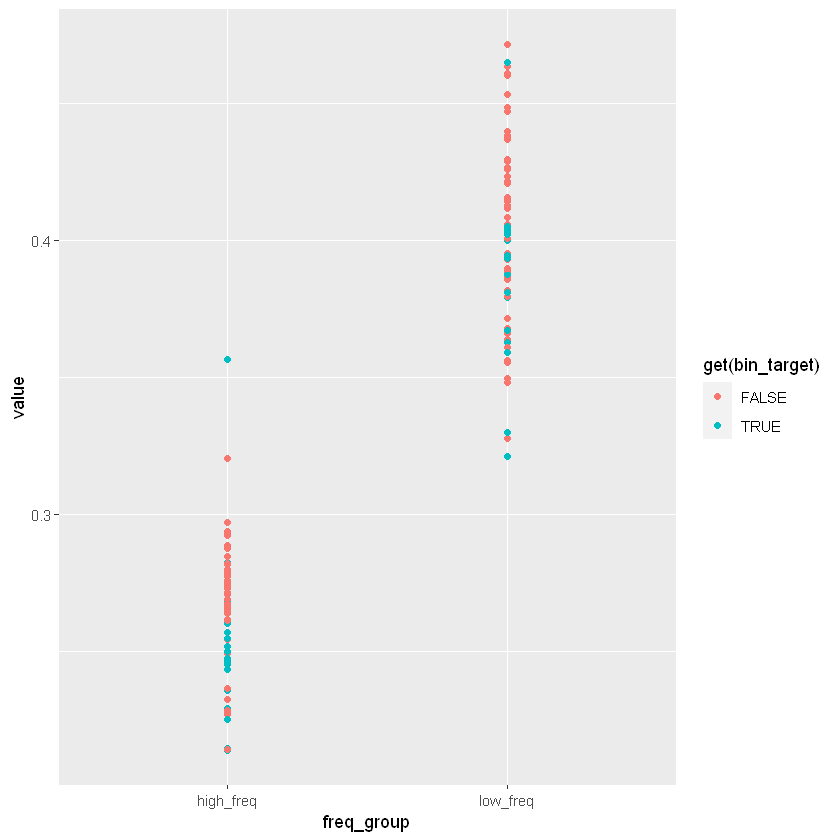

In [164]:
df2 %>%
    filter(
        spectrum_0 < 0.5 &
        (get(target) > quantile(get(target), 0.75) | 
        get(target) < quantile(get(target), 0.75))
    ) %>%
    select(- target) %>%
    pivot_longer(
        cols = !c(!!bin_target, folio), 
        names_to = "series",
        values_to = "value",
        values_drop_na = TRUE
    ) %>%
    mutate(
        serie = str_replace(series, "_.*", ""),
        freq = as.numeric(str_replace(series, ".*_", ""))
    ) %>%
    filter(
        serie == 'spectrum',
        freq %in% c(50:150, 220:230)
    ) %>%
    ungroup() %>%
    mutate(freq_group = ifelse(freq %in% 50:150, "low_freq", "high_freq")) %>%
    group_by(.dots = bin_target, freq_group, folio) %>%
    summarize(value = mean(value)) %>%
    ungroup() %>%
    ggplot(aes(
        x = freq_group,
        y = value,
        color = get(bin_target),
        group = folio
        )
    ) +
        geom_point()
        

In [12]:
target = "DXA_densidad"
bin_target = paste(target, "bin", sep="_")

df2 = df %>%
    drop_na() %>%
    group_by(folio) %>%
    summarise(
        !!target := first(get(target)),
        Peso = first(Peso),
        edad = first(edad),
        BMI = first(Indice.de.Masa.Corporal),
        copa_sosten = first(copa_sosten),
        across(starts_with("spectrum"), mean), 
        across(starts_with("sample_raw"), mean)
    ) %>%
    mutate(
        !!bin_target := ifelse(get(target) > quantile(get(target), 0.75), "high_density", "low_density"),
        BMI_segment = case_when(
            BMI < 18 ~ "<18",
            BMI < 25 ~ "18-25",
            BMI < 30 ~ "25-30",
            TRUE ~ ">30"
        ),
        peso_segment = case_when(
            Peso < quantile(Peso, 0.25) ~ "peso_1_Quartil",
            Peso < quantile(Peso, 0.5) ~ "peso_2_Quartil",
            Peso < quantile(Peso, 0.75) ~ "peso_3_Quartil",
            TRUE ~ "peso_4_Quartil"
        )
    )

`summarise()` ungrouping output (override with `.groups` argument)



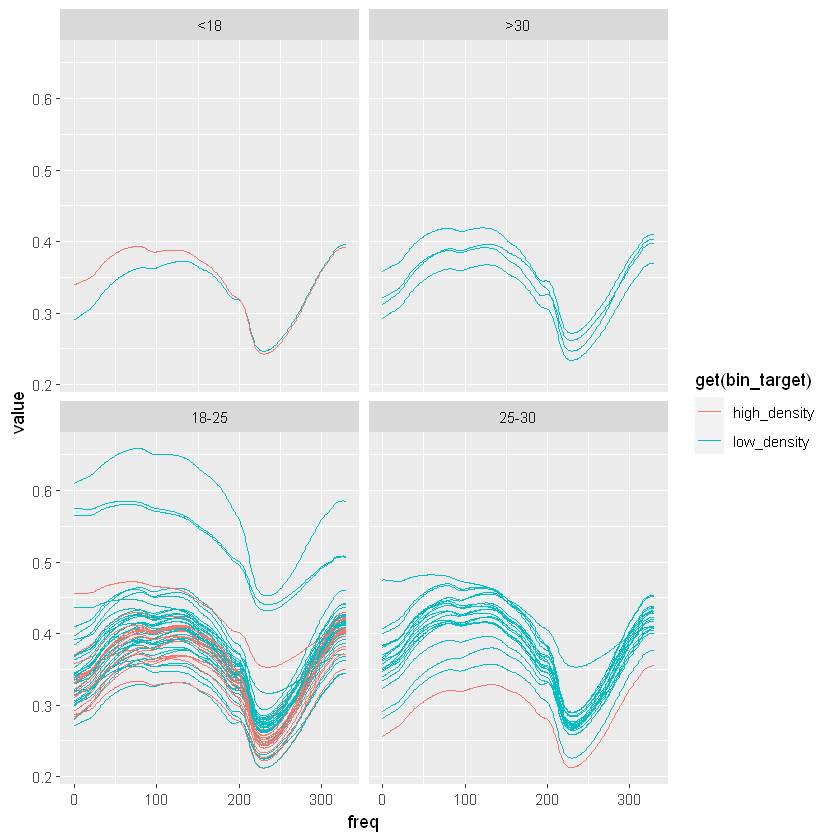

In [13]:
df2 %>%
    filter(
        get(target) > quantile(get(target), 0.75) | 
        get(target) < quantile(get(target), 0.75)
    ) %>%
    select(- c(target, BMI, Peso)) %>%
    pivot_longer(
        cols = !c(!!bin_target, BMI_segment, folio, copa_sosten, peso_segment, edad), 
        names_to = "series",
        values_to = "value",
        values_drop_na = TRUE
    ) %>%
    mutate(
        serie = str_replace(series, "_.*", ""),
        freq = as.numeric(str_replace(series, ".*_", ""))
    ) %>%
    filter(serie == 'spectrum') %>%
    ungroup() %>%
#     group_by(.dots = bin_target, freq, BMI_segment) %>%
#     summarize(value = mean(value)) %>%
#     ungroup()  %>%
    ggplot(aes(
        x = freq, 
        y = value, 
        color = get(bin_target),
        group = folio
        )
    ) +
    geom_line() +
    facet_wrap(~ BMI_segment)

`summarise()` regrouping output by 'freq', 'BMI_segment' (override with `.groups` argument)



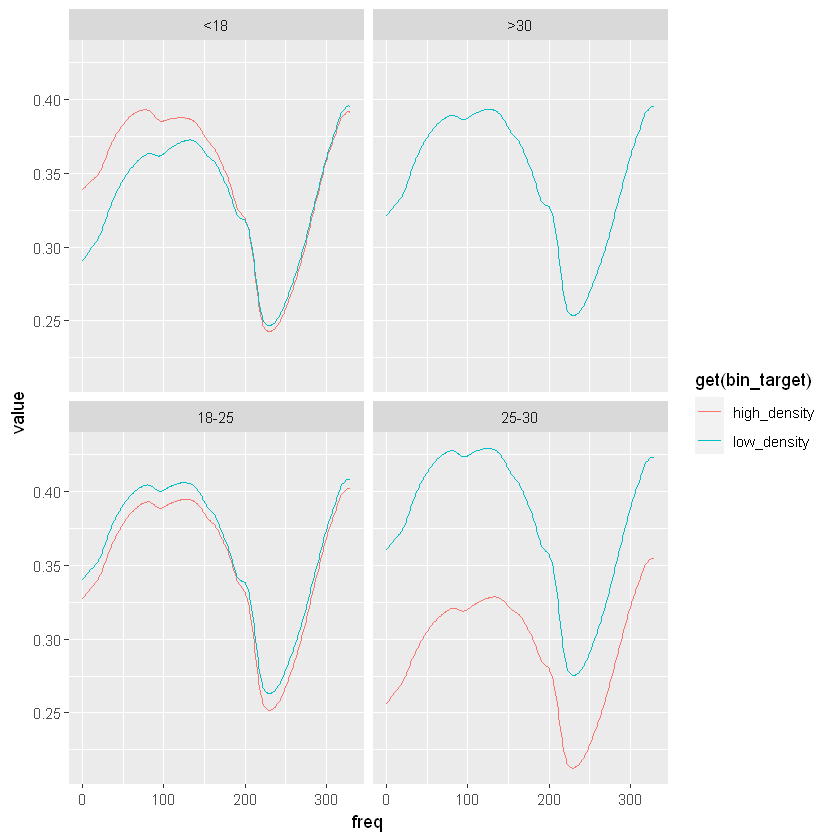

In [21]:
df2 %>%
    filter(
        spectrum_1 < 0.5
    ) %>%
    select(- c(target, BMI, Peso)) %>%
    pivot_longer(
        cols = !c(!!bin_target, BMI_segment, folio, copa_sosten, peso_segment, edad), 
        names_to = "series",
        values_to = "value",
        values_drop_na = TRUE
    ) %>%
    mutate(
        serie = str_replace(series, "_.*", ""),
        freq = as.numeric(str_replace(series, ".*_", ""))
    ) %>%
    filter(serie == 'spectrum') %>%
    ungroup() %>%
    group_by(.dots = bin_target, freq, BMI_segment) %>%
    summarize(value = mean(value)) %>%
    ungroup()  %>%
    ggplot(aes(
        x = freq, 
        y = value, 
        color = get(bin_target),
#         group = folio
        )
    ) +
    geom_line() +
    facet_wrap(~ BMI_segment)

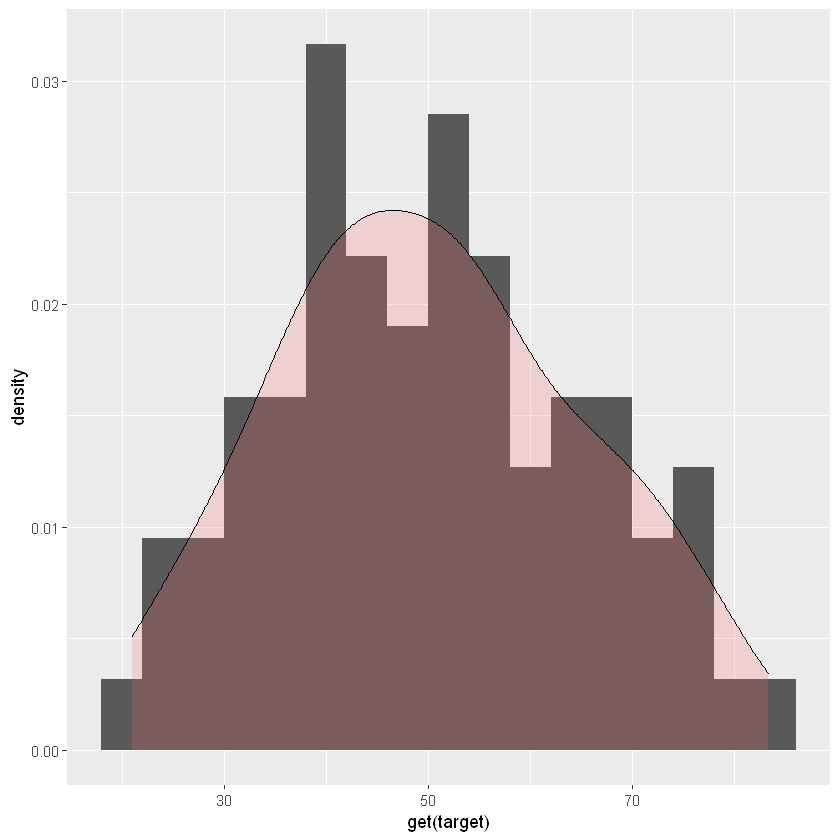

In [40]:
df2 %>%
    ggplot(aes(x = get(target))) +
    geom_histogram(aes(y=..density..), binwidth=4)+
    geom_density(alpha=.2, fill="#FF6666") 

In [6]:
nrow(df2)

[1] 79